<div><center><img src="https://ml.ucv.ai/logo.png\" width=150"/> </center></div>

# 04 Segmentación de imágenes con redes U-Net


Basado en:

- [Efficient Image Segmentation](https://medium.com/data-science/efficient-image-segmentation-using-pytorch-part-3-3534cf04fb89)
- [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/)



# 1. Arquitecturas Encoder-Decoder (Teoría y Fórmulas)

Un modelo **encoder-decoder** transforma una entrada $ \mathbf{x} \in \mathbb{R}^n $ en una salida $ \mathbf{y} \in \mathbb{R}^m $ mediante una representación latente $ \mathbf{z} \in \mathbb{R}^d $, donde normalmente $ d < n $.

## 1.1 Encoder

El **encoder** convierte la entrada $ \mathbf{x} $ en una representación latente $ \mathbf{z} $:

$$
\mathbf{z} = f_{\text{enc}}(\mathbf{x}; \theta_e)
$$

- $ f_{\text{enc}} $: red neuronal (CNN, RNN, MLP, etc.)
- $ \theta_e $: parámetros del encoder
- $ \mathbf{z} $: vector latente comprimido

Si el encoder tiene múltiples capas:

$$
\mathbf{z} = f_L \circ f_{L-1} \circ \dots \circ f_1(\mathbf{x})
$$

En términos de dominio y codominio:

$$
f_{\text{enc}}: \mathbb{R}^n \rightarrow \mathbb{R}^d
$$

- $ \mathbf{x} \in \mathbb{R}^n $: entrada original
- $ \mathbf{z} = f_{\text{enc}}(\mathbf{x}) \in \mathbb{R}^d $: representación latente
- Típicamente $ d < n $ para compresión


## 1.2. Decoder

El **decoder** reconstruye o genera la salida a partir de $ \mathbf{z} $:

$$
\hat{\mathbf{y}} = f_{\text{dec}}(\mathbf{z}; \theta_d)
$$

- $ f_{\text{dec}} $: red decodificadora
- $ \theta_d $: parámetros del decoder
- $ \hat{\mathbf{y}} $: salida generada o reconstruida

Reconstruye o genera la salida desde el espacio latente:

$$
f_{\text{dec}}: \mathbb{R}^d \rightarrow \mathbb{R}^m
$$

- $ \mathbf{z} \in \mathbb{R}^d $: vector latente
- $ \hat{\mathbf{y}} = f_{\text{dec}}(\mathbf{z}) \in \mathbb{R}^m $: salida reconstruida o generada


## 1.3. El modelo

El modelo completo es la composición de encoder y decoder:

$$
f_{\text{dec}} \circ f_{\text{enc}}: \mathbb{R}^n \rightarrow \mathbb{R}^m
$$

Es decir:

$$
\hat{\mathbf{y}} = f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))
$$


## 1.4. Función de Pérdida

El modelo se entrena minimizando la pérdida entre la salida generada $ \hat{\mathbf{y}} $ y la salida real $ \mathbf{y} $:

$$
\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = \mathcal{L}\left(\mathbf{y}, f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))\right)
$$

### Ejemplos comunes:

- **Reconstrucción (autoencoder):**

$$
\mathcal{L} = \|\mathbf{x} - f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))\|^2
$$

- **Segmentación (por píxel):**

$$
\mathcal{L} = \text{CrossEntropy}(\mathbf{y}, \hat{\mathbf{y}})
$$

- **Secuencia a secuencia (traducción):**

$$
\mathcal{L} = -\sum_{t=1}^T \log P(y_t \mid \mathbf{z}, y_{<t})
$$



## 1.4. Optimización

El entrenamiento ajusta los parámetros del modelo $ \theta = \{\theta_e, \theta_d\} $ para minimizar la pérdida esperada:

$$
\theta^* = \arg \min_{\theta} \ \mathbb{E}_{(\mathbf{x}, \mathbf{y}) \sim \mathcal{D}} \left[ \mathcal{L}(\mathbf{y}, f_{\text{dec}}(f_{\text{enc}}(\mathbf{x}))) \right]
$$

Donde $ \mathcal{D} $ es el conjunto de datos de entrenamiento.



# 3. Segmentación

In [110]:
!pip install torchinfo

In [111]:
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from dataclasses import dataclass
import dataclasses
from torchinfo import summary

In [112]:
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

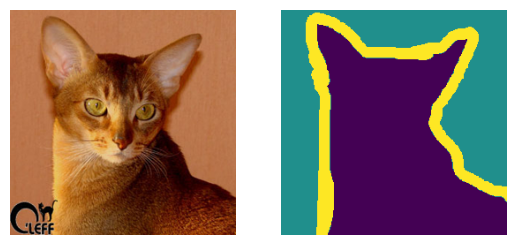

In [113]:
import requests

def get_unsplash_image():
    image_path = "stroller-unsplash.avif"

    if not os.path.exists(image_path):
        url = "https://images.unsplash.com/photo-1687017563985-a7193fcd7032"
        r = requests.get(url, allow_redirects=True)
        with open(image_path, 'wb') as fp:
            fp.write(r.content)
        # end with
    # end if

    image_256_path = "stroller-unsplash-256.png"

    if not os.path.exists(image_256_path):
        img = Image.open(image_path)
        img = img.resize((256, 256))
        img = img.convert("RGB")
        img.save(image_256_path)
    # end if

    img = Image.open(image_256_path)
    return img

def get_pet_cat_image_and_mask():
    img = Image.open(r"images/Abyssinian_169.jpg")
    img = img.convert("RGB").resize((256, 256))

    mask = Image.open(r"annotations/trimaps/Abyssinian_169.png")
    mask = mask.convert("L").resize((256, 256))
    mask = t2img((img2t(mask) * 255. - 1.) / 2.)
    return img, mask

img, mask = get_pet_cat_image_and_mask()

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis("off")

plt.show()

## 3.2 Descargar los datos

In [114]:
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

['--2025-07-20 23:58:21--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz',
 'Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2',
 'Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.',
 'HTTP request sent, awaiting response... 301 Moved Permanently',
 'Location: https://thor.robots.ox.ac.uk/pets/annotations.tar.gz [following]',
 '--2025-07-20 23:58:22--  https://thor.robots.ox.ac.uk/pets/annotations.tar.gz',
 'Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98',
 'Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 19173078 (18M) [application/octet-stream]',
 'Saving to: ‘annotations.tar.gz.1’',
 '',
 '',
 'annotations.tar.gz.   0%[                    ]       0  --.-KB/s               ',
 'annotations.tar.gz.   0%[                    ]  71.77K   279KB/s               ',
 'annotations.tar.gz.   1%

In [115]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

## 3.3 Preparar los nombres de las imágenes y las máscaras

In [116]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Número de imágenes:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Número de imágenes: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## 3.4 Cargando las imágenes usando Keras

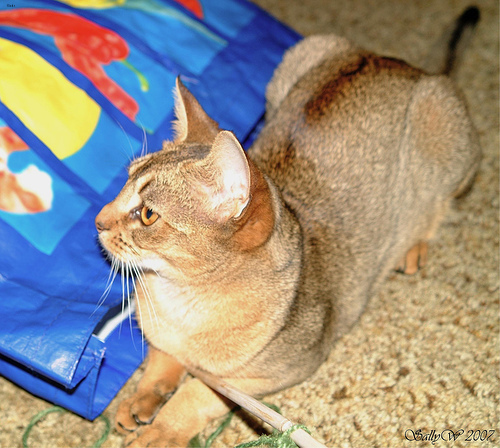

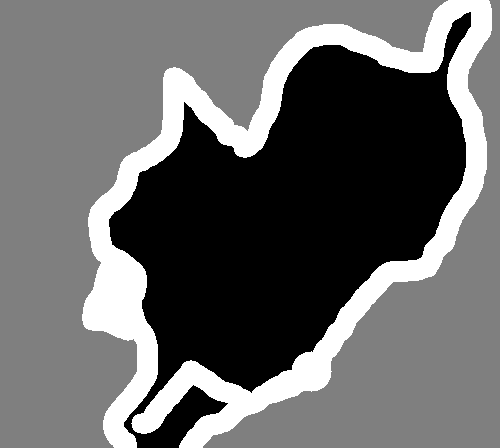

In [117]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## 3.5 Preparar dataset y batches de data

In [118]:
import keras
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## 3.6 Modelo U-Net Xception-style

In [119]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_187 (Conv2D) │ (None, 80, 80,    │        896 │ input_layer_26[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_187[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_344      │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_345      │ (None, 80, 80,    │          0 │ activation_344[0… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 80, 80,    │      2,400 │ activation_345[0… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_346      │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 80, 80,    │      4,736 │ activation_346[0… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_77    │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 40, 40,    │      2,112 │ activation_344[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_159 (Add)       │ (None, 40, 40,    │          0 │ max_pooling2d_77… │
│                     │ 64)               │            │ conv2d_188[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_347      │ (None, 40, 40,    │          0 │ add_159[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1… │ (None, 40, 40,    │      8,896 │ activation_347[0… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_348      │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## 3.7 Split de validación

In [122]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

## Entrenamiento con Métricas específicas del dominio

Dependiendo del contexto en el que entrenemos modelos, a veces tiene sentido modificar la métrica de interés. Por ejemplo, en [Image segmentation metrics](https://keras.io/api/metrics/segmentation_metrics/) encontramos:

In [123]:
import tensorflow as tf

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


In [124]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy",
    metrics=[iou_metric, dice_coefficient]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True),
    keras.callbacks.TensorBoard('./logs', update_freq=1)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
32/32 - 54s - 2s/step - dice_coefficient: 0.8584 - iou_metric: 0.7523 - loss: 0.7225 - val_dice_coefficient: 0.9031 - val_iou_metric: 0.8239 - val_loss: 2.5498
Epoch 2/50
32/32 - 8s - 239ms/step - dice_coefficient: 0.8473 - iou_metric: 0.7353 - loss: 0.5758 - val_dice_coefficient: 0.9031 - val_iou_metric: 0.8240 - val_loss: 1.6865
Epoch 3/50
32/32 - 10s - 323ms/step - dice_coefficient: 0.8472 - iou_metric: 0.7352 - loss: 0.5418 - val_dice_coefficient: 0.9025 - val_iou_metric: 0.8229 - val_loss: 1.4142
Epoch 4/50
32/32 - 9s - 290ms/step - dice_coefficient: 0.8477 - iou_metric: 0.7359 - loss: 0.5134 - val_dice_coefficient: 0.9001 - val_iou_metric: 0.8190 - val_loss: 1.1946
Epoch 5/50
32/32 - 8s - 236ms/step - dice_coefficient: 0.8488 - iou_metric: 0.7376 - loss: 0.4848 - val_dice_coefficient: 0.8962 - val_iou_metric: 0.8125 - val_loss: 1.0252
Epoch 6/50
32/32 - 9s - 292ms/step - dice_coefficient: 0.8506 - iou_metric: 0.7403 - loss: 0.4553 - val_dice_coefficient: 0.8921 - val_i

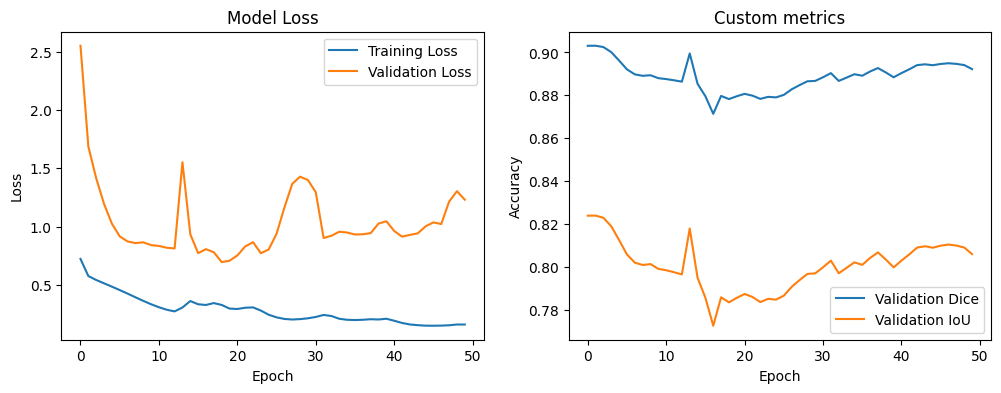

In [125]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.title('Custom metrics')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step


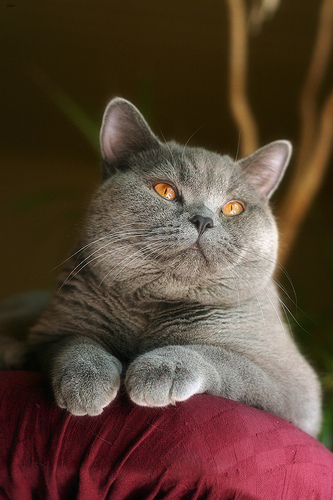

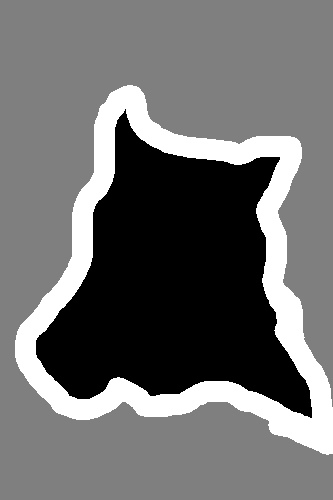

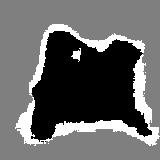

In [126]:
# Generate predictions for all images in the validation set
from keras.models import load_model

model_name = "models/UCV-1000.keras"

#if model is None:
  # Load the model
  #model = load_model(model_name)

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.